# <u>Assignment 5</u>:

## WEEK 5: House Price Prediction Model

### Bengaluru House Price Dataset


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 

In [2]:
house=pd.read_csv("Bengaluru_House_Data.csv")

In [3]:
house.shape

(13320, 9)

In [4]:
house.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
house.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


---
#### Column types found:
- `Numerical:` bath, balcony, price(target)
- `Categorical:` size, availability, area_type
- `Mixed:` location, society
---

In [7]:
house.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

---
## Univariate Analysis & Data Cleaning

Now we’ll explore each column individually to understand:
- The distribution 
- Summary statistics of numerical features
- Missing value treatment

### Plan for Cleaning:
- Convert `size` (e.g., "2 BHK", "4 Bedroom") to a new column `bhk` as numeric.
- Handle missing values:
  - Drop rows with null in crucial fields (`bath`, `total_sqft`, `price`, `bhk`)
  - Decide what to do with less important columns (`society`, `balcony`) later
 ---

In [8]:
house['bhk']=house['size'].str.extract(r'(\d+)').astype(float)

In [9]:
house['bhk']

0        2.0
1        4.0
2        3.0
3        3.0
4        2.0
        ... 
13315    5.0
13316    4.0
13317    2.0
13318    4.0
13319    1.0
Name: bhk, Length: 13320, dtype: float64

In [10]:
house=house.dropna(subset=['location','size','bath'])

In [11]:
house['balcony']=house['balcony'].fillna(house['balcony'].median())

In [12]:
house.isnull().sum()

area_type          0
availability       0
location           0
size               0
society         5499
total_sqft         0
bath               0
balcony            0
price              0
bhk                0
dtype: int64

In [13]:
house.describe()

,bath,balcony,price,bhk
count,13246.000000,13246.000000,13246.000000,13246.000000
mean,2.692586,1.601163,112.389392,2.801902
std,1.341506,0.804759,149.076587,1.295758
min,1.000000,0.000000,8.000000,1.000000
25%,2.000000,1.000000,50.000000,2.000000
50%,2.000000,2.000000,72.000000,3.000000
75%,3.000000,2.000000,120.000000,3.000000
max,40.000000,3.000000,3600.000000,43.000000


Text(0.5, 1.0, 'Price Distribution')

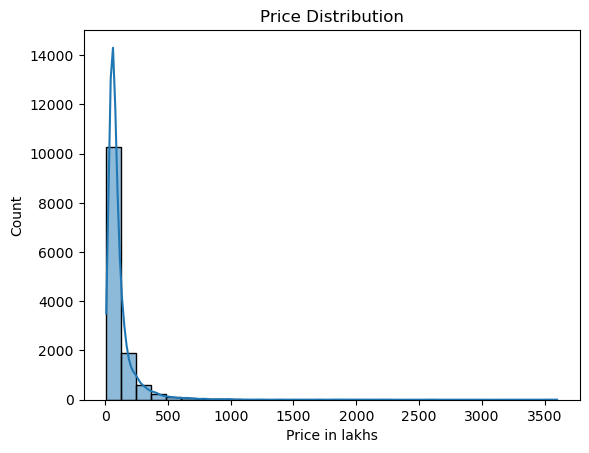

In [14]:
sns.histplot(house['price'], kde=True, bins=30)
plt.xlabel('Price in lakhs')
plt.title('Price Distribution')

Text(0.5, 1.0, 'Total Sqft Distribution')

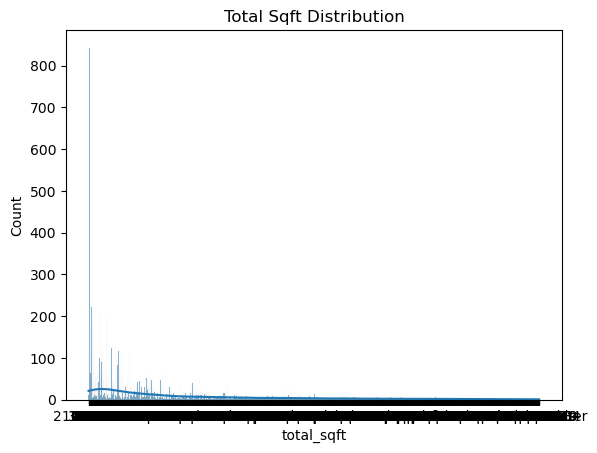

In [15]:
sns.histplot(house['total_sqft'], kde=True, bins=10)
plt.title('Total Sqft Distribution')

## Fixing total_sqft for Better Distribution Analysis

Some values in `total_sqft` column are not single numbers, e.g.:

- Ranges: `'2100 - 2850'`
- Units: `'34.46Sq. Meter'`

We’ll:
1. Convert ranges like `'2100 - 2850'` to their average
2. Remove non-numeric entries or try converting to sqft
3. Plot again after filtering out extreme outliers

We'll also create a cleaned numeric version: `total_sqft_cleaned`

In [16]:
def clean_total_sqft(val):
    if isinstance(val, str):
        if '-' in val:
            parts = val.split('-')
            if len(parts) == 2 and parts[0].strip().isdigit() and parts[1].strip().isdigit():
                return (float(parts[0]) + float(parts[1])) / 2
        if val.replace('.', '', 1).isdigit():  # if it's a float-like string
            return float(val)
    elif isinstance(val, (int, float)):
        return val
    return None

house['total_sqft_cleaned'] = house['total_sqft'].apply(clean_total_sqft)

In [17]:
house = house[house['total_sqft_cleaned'].notnull()]
house['total_sqft_cleaned'] = house['total_sqft_cleaned'].astype(float)

In [18]:
house['total_sqft'].sample(10)

8358     1205
878      1360
7350      750
2553     1238
6129     1987
706      2264
11724    1170
58       1407
2072     1100
9642      605
Name: total_sqft, dtype: object

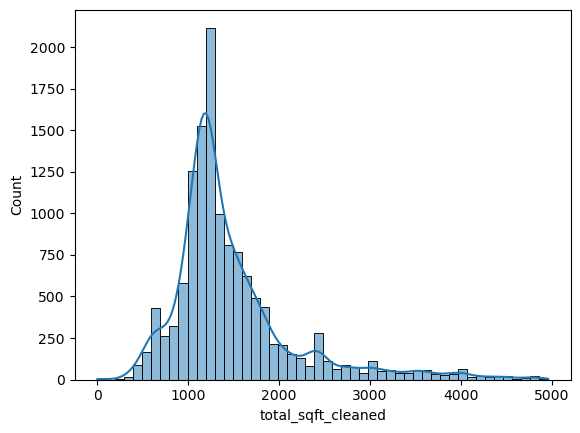

In [19]:
sns.histplot(house[house['total_sqft_cleaned'] < 5000]['total_sqft_cleaned'], bins=50, kde=True)
plt.show()

Text(0.5, 1.0, 'BHK Count Distribution')

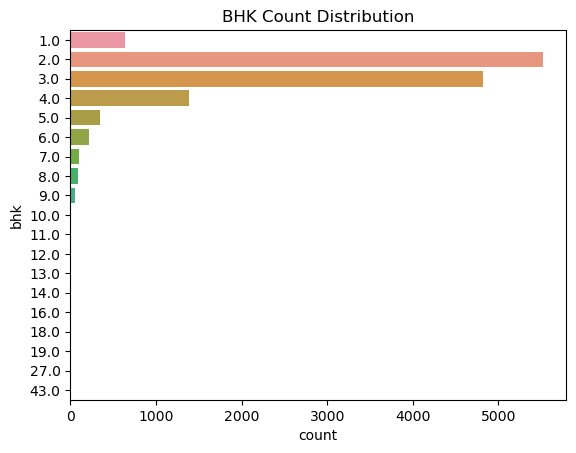

In [20]:
sns.countplot(y='bhk', data=house)
plt.title('BHK Count Distribution')

## Bivariate & Multivariate Analysis

Text(0.5, 1.0, 'Total Sqft vs Price')

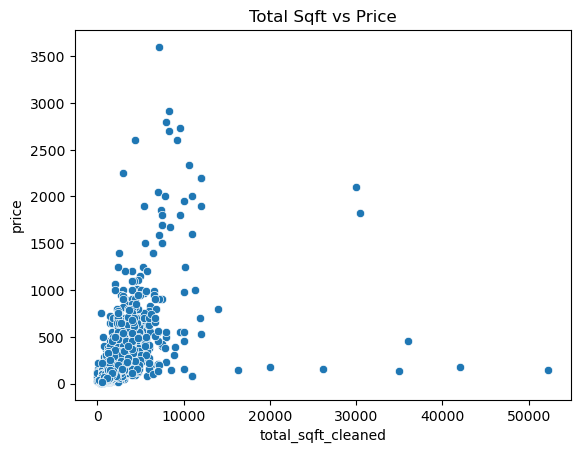

In [21]:
sns.scatterplot(x='total_sqft_cleaned', y='price', data=house)
plt.title('Total Sqft vs Price')

---
## Feature Engineering & Correlation Analysis

We now aim to:
1. Identify which columns most influence the `price`
2. Remove weak or irrelevant features
3. Engineer useful new features (like `price_per_sqft`)
4. Prepare for model training with only the most useful columns

We'll use:
- Correlation heatmaps
- Common-sense feature creation (e.g., price per sqft)
- Logical reasoning to drop non-informative features
---

In [22]:
house['price_per_sqft'] = house['price'] * 100000 / house['total_sqft_cleaned']
house['price_per_sqft'].head()

0    3699.810606
1    4615.384615
2    4305.555556
3    6245.890861
4    4250.000000
Name: price_per_sqft, dtype: float64

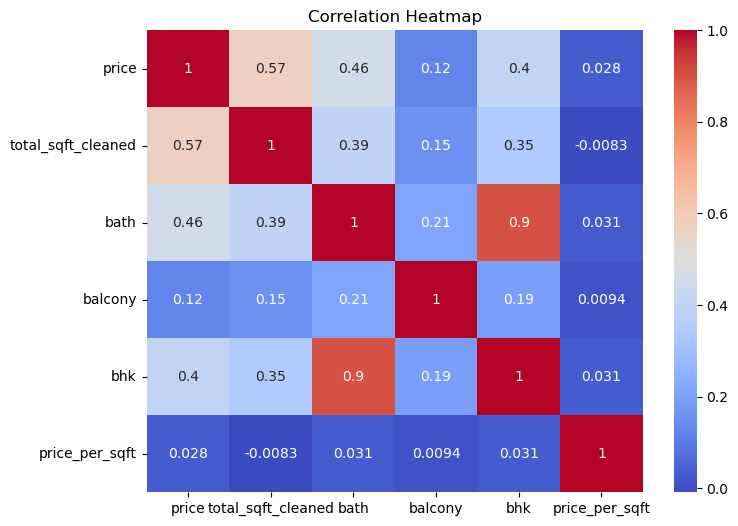

In [23]:
numeric_cols = ['price', 'total_sqft_cleaned', 'bath', 'balcony', 'bhk', 'price_per_sqft']
correlation_matrix = house[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [24]:
house.groupby('location')['price'].mean().sort_values(ascending=False).head(10)

location
Cubbon Road            1900.000000
Ashok Nagar            1486.000000
Defence Colony         1167.714286
Yemlur                 1093.388889
Church Street          1068.000000
D Souza Layout         1015.000000
Sadashiva Nagar        1011.100000
Sindhi Colony           988.000000
Srinivas Colony         922.000000
5th Block Jayanagar     905.000000
Name: price, dtype: float64

In [31]:
house['location'].nunique()

1298

In [36]:
location_counts = house['location'].value_counts()
print(location_counts)

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: count, Length: 1298, dtype: int64


### Reduce Locations by Frequency
Keep only the top 10 or 20 most frequent locations, and label the rest as `"other"`.

In [48]:
location_threshold = 50
house['location_reduced'] = house['location'].apply(
    lambda x: x if location_counts[x] >= location_threshold else 'other'
)

## Trade-off Rule:
Rare locations (with < 50 records) don’t have enough data for the model to learn from — even if they’re expensive.

So grouping them into "other" actually improves model robustness, especially for regression.

In [49]:
house['location_reduced'].nunique()

55

In [25]:
house.groupby('availability')['price'].mean().sort_values(ascending=False)

availability
19-Jan    367.552051
20-May    323.500000
20-Jul    297.600000
15-Oct    280.500000
20-Apr    264.737500
             ...    
21-Oct     48.000000
14-Nov     43.710000
14-Jul     43.710000
19-Nov     42.797143
16-Nov     39.000000
Name: price, Length: 80, dtype: float64

### Lets work on availability
- Keeping only "Ready To Move" as `1` vs "Future Date" as `0` 2 categories 
(these numerical value will help analyze better)

In [27]:
house['availability_encoded'] = house['availability'].apply(lambda x: 1 if x == 'Ready To Move' or x=='Immediate Possession' else 0)

In [30]:
house['availability_encoded'].sample(10)

9846     1
8398     1
3912     1
3549     1
2214     0
5449     1
13045    1
4078     0
1537     1
10142    1
Name: availability_encoded, dtype: int64

In [26]:
house.groupby('society')['price'].mean().sort_values(ascending=False).head(10)

society
Kierser    2700.0
Epllan     1915.0
Adion A    1800.0
Phaku K    1500.0
Prood G    1250.0
LeeyaCa    1063.0
Prian E    1025.0
Niateki    1015.0
HMeuran     988.0
Masta A     986.0
Name: price, dtype: float64

In [39]:
house['society'].isnull().sum()

5469

### Society:
- society has 5469 missing values.
- Too many unique names (like Kierser, EpIlan, etc.)
- It might not generalize well in modeling.

In [50]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13197 entries, 0 to 13319
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   area_type             13197 non-null  object 
 1   availability          13197 non-null  object 
 2   location              13197 non-null  object 
 3   size                  13197 non-null  object 
 4   society               7728 non-null   object 
 5   total_sqft            13197 non-null  object 
 6   bath                  13197 non-null  float64
 7   balcony               13197 non-null  float64
 8   price                 13197 non-null  float64
 9   bhk                   13197 non-null  float64
 10  total_sqft_cleaned    13197 non-null  float64
 11  price_per_sqft        13197 non-null  float64
 12  availability_encoded  13197 non-null  int64  
 13  location_reduced      13197 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 1.5+ MB


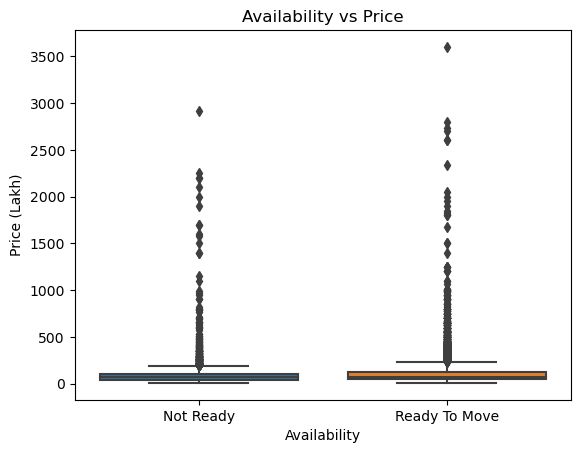

In [51]:
sns.boxplot(data=house, x='availability_encoded', y='price')
plt.xticks([0, 1], ['Not Ready', 'Ready To Move'])
plt.title('Availability vs Price')
plt.ylabel('Price (Lakh)')
plt.xlabel('Availability')
plt.show()

## Insight:
- Availability status has minimal impact on price.
- Buyers may not pay significantly more for “Ready to Move” properties.
- Could be a weak predictor for regression.

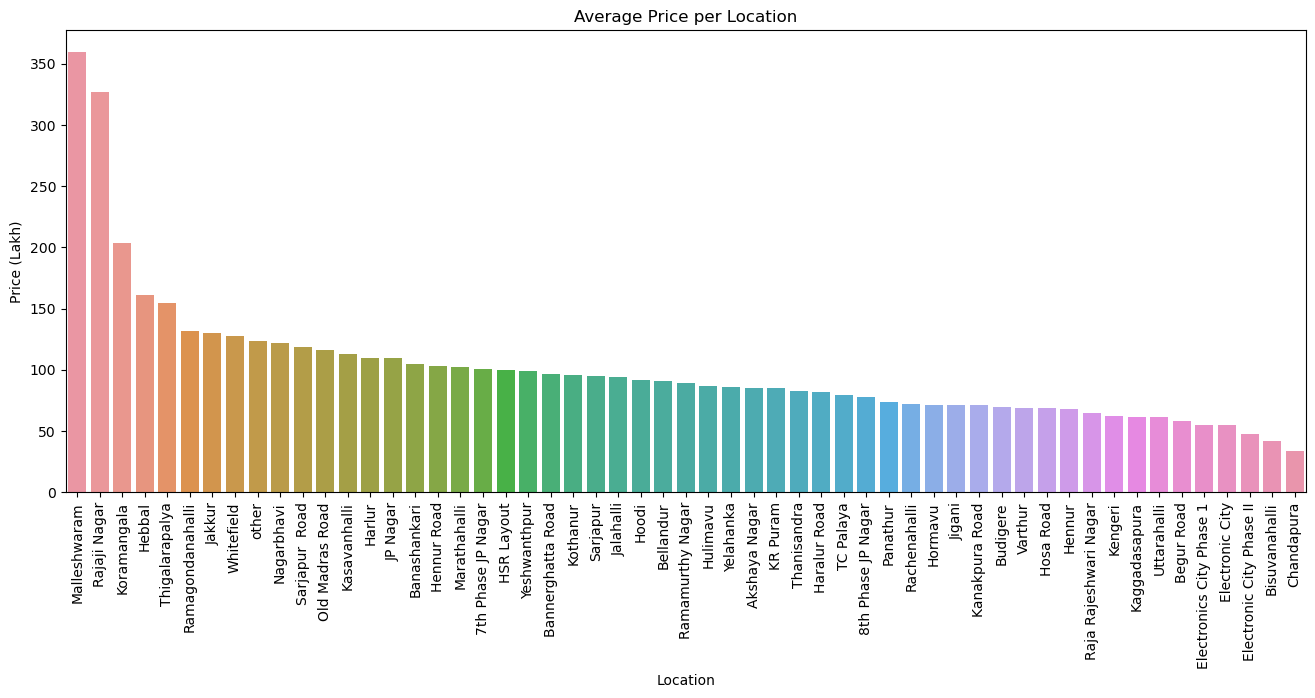

In [53]:
plt.figure(figsize=(16, 6))
location_avg_price = house.groupby('location_reduced')['price'].mean().sort_values(ascending=False)
sns.barplot(x=location_avg_price.index, y=location_avg_price.values)
plt.xticks(rotation=90)
plt.title('Average Price per Location')
plt.ylabel('Price (Lakh)')
plt.xlabel('Location')
plt.show()

----
## Final Set of Features for Regression

| Feature               | Description                                 | Type        | Why It's Included                               |
|------------------------|---------------------------------------------|-------------|--------------------------------------------------|
| `total_sqft_cleaned`   | Cleaned total area in sqft                  | Numerical   | Strong correlation with price (0.57)             |
| `bath`                 | Number of bathrooms                         | Numerical   | Good correlation (0.46), closely tied to price   |
| `bhk`                  | Number of bedrooms                          | Numerical   | Moderate correlation (0.40), useful              |
| `availability_encoded` | Ready to move or not (1 = Yes, 0 = No)      | Binary      | Weak impact but retained for testing             |
| `location_reduced_*`   | Location encoded using one-hot              | Categorical | Location is one of the most influential factors  |

### Optional Features (Can Experiment with):

| Feature           | Description                        | Type      | Notes                                         |
|-------------------|------------------------------------|-----------|-----------------------------------------------|
| `balcony`         | Number of balconies                | Numerical | Weak correlation, may or may not help         |
| `price_per_sqft`  | Price per square foot (in ₹)       | Numerical | Low correlation, may introduce extra noise    |

---
*We'll use them all initially and later evaluate which combination gives the best model performance.*

In [55]:
final_features = ['total_sqft_cleaned', 'bath', 'bhk', 'availability_encoded',
                  'balcony', 'price_per_sqft', 'location_reduced']

In [58]:
final_df = house[final_features + ['price']].dropna()

In [59]:
final_df

,total_sqft_cleaned,bath,bhk,availability_encoded,balcony,price_per_sqft,location_reduced,price
0,1056.0,2.0,2.0,0,1.0,3699.810606,Electronic City Phase II,39.07
1,2600.0,5.0,4.0,1,3.0,4615.384615,other,120.00
2,1440.0,2.0,3.0,1,3.0,4305.555556,Uttarahalli,62.00
3,1521.0,3.0,3.0,1,1.0,6245.890861,other,95.00
4,1200.0,2.0,2.0,1,1.0,4250.000000,Kothanur,51.00
...,...,...,...,...,...,...,...,...
13315,3453.0,4.0,5.0,1,0.0,6689.834926,Whitefield,231.00
13316,3600.0,5.0,4.0,1,2.0,11111.111111,other,400.00
13317,1141.0,2.0,2.0,1,1.0,5258.545136,Raja Rajeshwari Nagar,60.00
13318,4689.0,4.0,4.0,0,1.0,10407.336319,other,488.00


### One-Hot Encoding of Categorical Feature `location_reduced` column

In [60]:
houseF = final_df.copy()

# One-hot encode location_reduced
houseF = pd.get_dummies(houseF, columns=['location_reduced'], drop_first=True)

# Confirm shape and columns
print("Final dataset shape:", houseF.shape)
houseF.head()

Final dataset shape: (13197, 61)


,total_sqft_cleaned,bath,bhk,availability_encoded,balcony,price_per_sqft,price,location_reduced_8th Phase JP Nagar,location_reduced_Akshaya Nagar,location_reduced_Banashankari,...,location_reduced_Sarjapur Road,location_reduced_TC Palaya,location_reduced_Thanisandra,location_reduced_Thigalarapalya,location_reduced_Uttarahalli,location_reduced_Varthur,location_reduced_Whitefield,location_reduced_Yelahanka,location_reduced_Yeshwanthpur,location_reduced_other
0,1056.0,2.0,2.0,0,1.0,3699.810606,39.07,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2600.0,5.0,4.0,1,3.0,4615.384615,120.00,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,1440.0,2.0,3.0,1,3.0,4305.555556,62.00,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,1521.0,3.0,3.0,1,1.0,6245.890861,95.00,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,1200.0,2.0,2.0,1,1.0,4250.000000,51.00,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
final_df.to_csv("final_df.csv", index=False)
houseF.to_csv("houseF_encoded.csv", index=False)

## Split Dataset into Features (X) and Target (y)

We'll now split the final dataset:
- `X` (input features): all columns except `price`
- `y` (target): the `price` column

Then, we'll divide them into training and testing sets using an 80-20 split.

In [74]:
X = houseF.drop('price', axis=1)
y = houseF['price']

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (10557, 60)
X_test shape: (2640, 60)


## Training Linear Regression Model

In [77]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [78]:
y_pred

array([ 60.45262688, 124.37075197, 103.37361962, ...,  -3.37149821,
       172.24458336,  62.82354634])

In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.2f} Lakhs")
print(f"RMSE     : {rmse:.2f} Lakhs")

Model Performance Metrics:
R² Score : 0.4447
MAE      : 45.29 Lakhs
RMSE     : 115.35 Lakhs


## Trying without experimental features

In [69]:
# Drop weak features
houseF_cleaned = houseF.drop(columns=['balcony', 'price_per_sqft', 'availability_encoded'])

In [70]:
X = houseF_cleaned.drop(columns=['price'])
y = houseF_cleaned['price']

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [72]:
from sklearn.linear_model import LinearRegression

model_cleaned = LinearRegression()
model_cleaned.fit(X_train, y_train)
y_pred_cleaned = model_cleaned.predict(X_test)


In [73]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_cleaned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_cleaned))
r2 = r2_score(y_test, y_pred_cleaned)

print("Model Performance (Cleaned Features):")
print(f"R² Score : {r2:.4f}")
print(f"MAE      : {mae:.2f} Lakhs")
print(f"RMSE     : {rmse:.2f} Lakhs")


Model Performance (Cleaned Features):
R² Score : 0.4439
MAE      : 45.41 Lakhs
RMSE     : 115.44 Lakhs


## Interpretation:

- The performance is almost identical to the model using all features.

- This means the removed features (balcony, price_per_sqft, availability_encoded) were not helping — and possibly even adding noise.

In [83]:
lr_model.score(X_test, y_test)

0.444724589363528

In [80]:
import pickle

# Save the model
with open("best_house_price_model.pkl", "wb") as f:
    pickle.dump(lr_model, f)

# Save the feature column names
with open("model_features.pkl", "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)
